In [ ]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw
import random

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git # puedes clonar el repositorio original de Mask RCNN donde se encuentra el modelo 
                                                       # o descargar la carpeta Mask_RCNN directamente de mi repositorio

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 18.02 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [ ]:
#Nos movemos a la siguiente carpeta:
os.chdir('/content/Mask_RCNN')

In [ ]:
!python setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:694: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'ma

In [ ]:
# Se establece la ruta de la carpeta raíz donde se encuentra el modelo Mask R-CNN
ROOT_DIR = '/content/Mask_RCNN'

# Se asegura de que la carpeta raíz existe en el sistema
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist'

# Se agrega la ruta de la carpeta raíz al sys.path para permitir que los módulos de Mask R-CNN se importen correctamente
sys.path.append(ROOT_DIR) 

# Se importan los módulos y funciones necesarios de Mask R-CNN.
from mrcnn import visualize    # Módulo para visualizar los resultados de la detección de objetos
from mrcnn.config import Config    # Clase para definir la configuración del modelo, con el tiempo esta clase se acutlizó y ahora genera incompativilidades. 
from mrcnn import model as modellib, utils    # Módulo principal para construir y entrenar el modelo, y módulo de funciones útiles para manipular datos y visualización

In [ ]:
# Establece la ruta donde se guardarán los pesos y configuraciones del modelo durante el entrenamiento
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Establece la ruta para el modelo pre-entrenado Mask R-CNN para la base de datos COCO
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Si el archivo mask_rcnn_coco.h5 no existe en la carpeta raíz, se descarga automáticamente utilizando la función download_trained_weights() del módulo utils de Mask R-CNN
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
class CustomConfig(Config):
    """Configuration for training on the helmet  dataset.
    """
    # nombre de la configuración
    NAME = "object"

    # número de GPU's a utilizar
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # número de clases a atilzar
    NUM_CLASSES = 1 + 2  # background + objetos

   # se establece la dimención mínima y la máxima de las imágenes
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 192
    

    # número de pasos por época durante el entrenamiento
    STEPS_PER_EPOCH = 500

    # número de pasos de validación durante el entrenamiento
    VALIDATION_STEPS = 5
    
    #  Se establece el modelo de backbone como resnet50, de lo contrario se usa resnet101 por
    BACKBONE = 'resnet50'

    # Se definen las escalas de anclaje de la región de interés (RPN)
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    # Número de regiones de interés (ROIs) por imagen que se utilizarán durante el entrenamiento
    TRAIN_ROIS_PER_IMAGE = 32

    # Número máximo de instancias positivas que se utilizarán en una sola imagen durante el entrenamiento
    MAX_GT_INSTANCES = 50 

    # Número de regiones de interés (ROIs) después de la supresión no máxima (NMS) durante la inferencia
    POST_NMS_ROIS_INFERENCE = 500 

    # Número de regiones de interés (ROIs) después de la supresión no máxima (NMS) durante el entrenamiento
    POST_NMS_ROIS_TRAINING = 1000 
    
config = SConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  192
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [192 192   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
# Clase que hereda de utils.Dataset de la librería Mask R-CNN
class CustomDataset(utils.Dataset):

    # Función para cargar el conjunto de datos de S
    def load_custom(self, dataset_dir, subset):
        """Load a subset of the bottle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # agregar las clases +1/2 y -1/2 al conjunto de datos con ID 1 y 2, respectivamente
        self.add_class("object", 1, "+1/2")
        self.add_class("object", 2, "-1/2")
 
        # Verificar si el conjunto de datos es de entrenamiento o de validación
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
 
        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region

        #cargar las anotaciones del conjunto de datos
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations1.values())  # don't need the dict keys
 
        # filtrar las anotaciones que no tiene regiones definidas
        annotations = [a for a in annotations if a['regions']]
 
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
          
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            objects = [s['region_attributes']['carga_topologica'] for s in a['regions'].values()]

            name_dict = {"+1/2": 1,"-1/2": 2}
            num_ids = [name_dict[a] for a in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            
            # Agregar la imagen y sus anotaciones al conjunto de datos
            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)
 
    # Función para cargar las máscaras de instancia de una imagen
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bottle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
 
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
 
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids
   #  la función obtiene la información asociada a esa imagen en el conjunto de datos a través de self.image_info[image_id]
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
# Creamos una instancia de la clase SDataset para el conjunto de entrenamiento
dataset_train = CustomDataset()
# Cargamos los datos de entrenamiento de la carpeta "train" dentro de la carpeta "data"
dataset_train.load_custom("/content/Mask_RCNN/data", "train")
# Preparamos los datos para ser utilizados en el modelo
dataset_train.prepare()

# Creamos una instancia de la clase SDataset para el conjunto de validación
dataset_val = CustomDataset()
# Cargamos los datos de validación de la carpeta "val" dentro de la carpeta "data"
dataset_val.load_custom("/content/Mask_RCNN/data", "val")    
# Preparamos los datos para ser utilizados en el modelo
dataset_val.prepare()

In [ ]:
# modelo de entrenamiento
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Define el valor de inicialización de los pesos del modelo.
init_with = "coco"  

# Carga los pesos pre-entrenados según la opción seleccionada
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Carga los pesos del último entrenamiento del modelo.
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
#comenzar el entrenamiento del modelo
model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=10, 
            layers='heads')


Starting at epoch 1. LR=0.001

Checkpoint Path: /content/MaskRCNN_Video/logs/object20210614T1520/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 2/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/ro

500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 2.6258 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 0.2338 - mrcnn_class_loss: 0.2731 - mrcnn_bbox_loss: 0.3423 - mrcnn_mask_loss: 0.4087

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


500/500 [==============================] - 165s 320ms/step - batch: 249.5000 - size: 1.0000 - loss: 2.6258 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 0.2338 - mrcnn_class_loss: 0.2731 - mrcnn_bbox_loss: 0.3423 - mrcnn_mask_loss: 0.4087 - val_loss: 2.2849 - val_rpn_class_loss: 0.0381 - val_rpn_bbox_loss: 0.2011 - val_mrcnn_class_loss: 0.2311 - val_mrcnn_bbox_loss: 0.3112 - val_mrcnn_mask_loss: 0.3610
Epoch 3/10
500/500 [==============================] - 162s 324ms/step - batch: 249.5000 - size: 1.0000 - loss: 2.3028 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 0.1940 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.2843 - mrcnn_mask_loss: 0.3783 - val_loss: 2.4525 - val_rpn_class_loss: 0.0264 - val_rpn_bbox_loss: 0.1995 - val_mrcnn_class_loss: 0.3043 - val_mrcnn_bbox_loss: 0.2964 - val_mrcnn_mask_loss: 0.3997
Epoch 4/10
500/500 [==============================] - 161s 323ms/step - batch: 249.5000 - size: 1.0000 - loss: 2.0422 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss

In [ ]:
# Creamos una nueva clase InferenceConfig que hereda de SConfig
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1 #cantidad de GPU a utilizar
    IMAGES_PER_GPU = 1 # Especificamos el número de imágenes que procesaremos en paralelo en cada GPU
    DETECTION_MIN_CONFIDENCE = 0.6
    
#se crea una instdancia de la clase InferenceConfig
inference_config = InferenceConfig()

In [ ]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
# obtenemos la ruta del modelo entrenado recientemente
model_path = model.find_last()

# verifica que se haya proporcionado la ruta para los pesos entrenados
assert model_path != "", "Provide path to trained weights"

# Cargamos los pesos del modelo desde la ruta proporcionada y los asigna al modelo actual utilizando el método load_weights().
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

/content/MaskRCNN_Video/images/val/Real_anch_theta_84_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


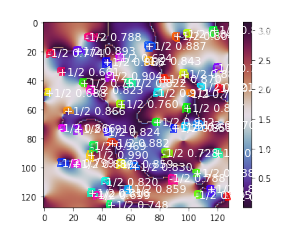

/content/MaskRCNN_Video/images/val/Real_anch_theta_89_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


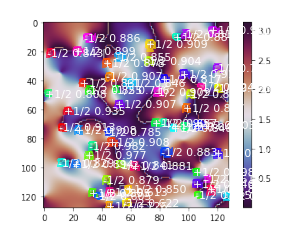

/content/MaskRCNN_Video/images/val/Real_anch_theta_82_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


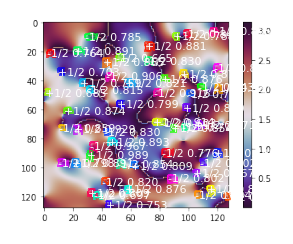

/content/MaskRCNN_Video/images/val/Real_anch_theta_88_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


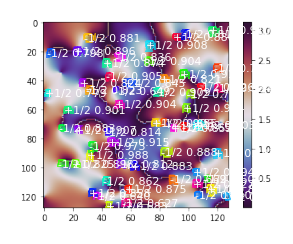

/content/MaskRCNN_Video/images/val/Real_anch_theta_91_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


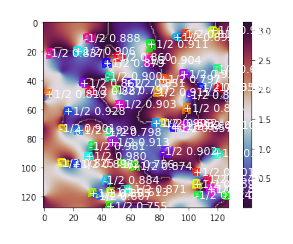

/content/MaskRCNN_Video/images/val/Real_anch_theta_97_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


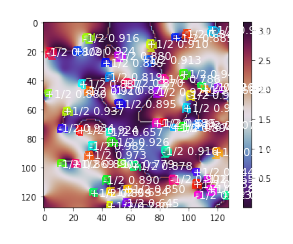

/content/MaskRCNN_Video/images/val/Real_anch_theta_86_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


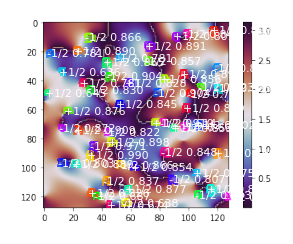

/content/MaskRCNN_Video/images/val/Real_anch_theta_100_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


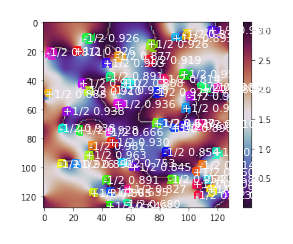

/content/MaskRCNN_Video/images/val/Real_anch_theta_92_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


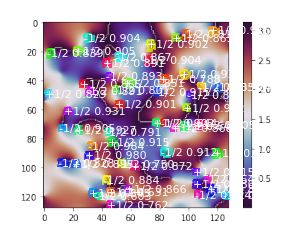

/content/MaskRCNN_Video/images/val/Real_anch_theta_94_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


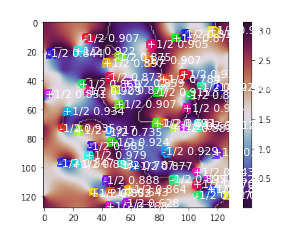

/content/MaskRCNN_Video/images/val/Real_anch_theta_90_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


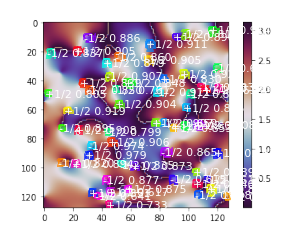

/content/MaskRCNN_Video/images/val/Real_anch_theta_83_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


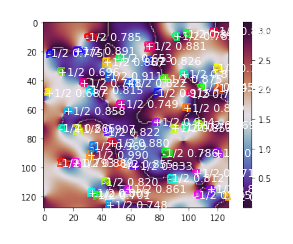

/content/MaskRCNN_Video/images/val/Real_anch_theta_98_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


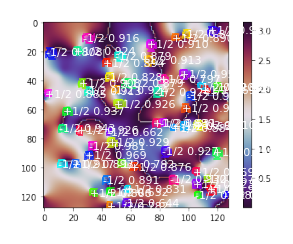

/content/MaskRCNN_Video/images/val/Real_anch_theta_95_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


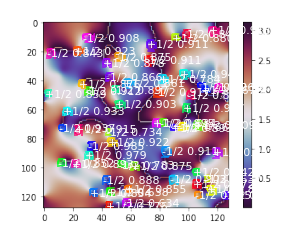

/content/MaskRCNN_Video/images/val/Real_anch_theta_93_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


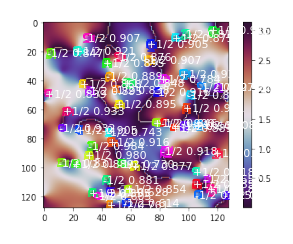

/content/MaskRCNN_Video/images/val/Real_anch_theta_99_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


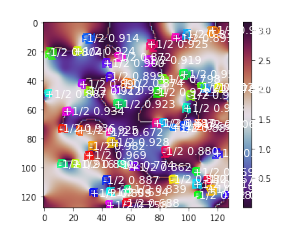

/content/MaskRCNN_Video/images/val/Real_anch_theta_96_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


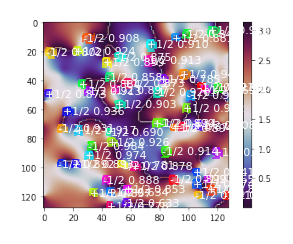

/content/MaskRCNN_Video/images/val/Real_anch_theta_85_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


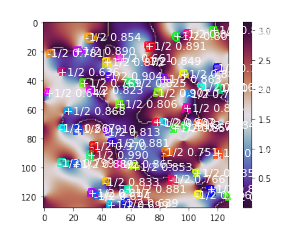

/content/MaskRCNN_Video/images/val/Real_anch_theta_87_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


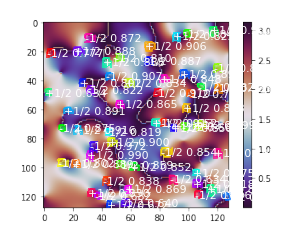

/content/MaskRCNN_Video/images/val/Real_anch_theta_81_nb_1.png
Processing 1 images
image                    shape: (251, 308, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 192, 192, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  308.00000  float64
anchors                  shape: (1, 9207, 4)          min:   -0.47387  max:    1.13879  float32


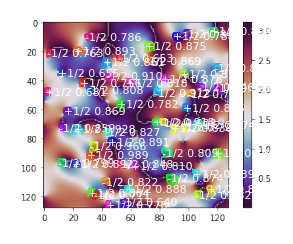

In [ ]:
# Importamos las bibliotecas necesarias
import skimage
import matplotlib.pyplot as plt

# Definimos el directorio de las imágenes de prueba
real_test_dir = '/content/Mask_RCNN/data/val/'
# Creamos una lista vacía para almacenar las rutas de las imágenes
image_paths = []

# Iteramos sobre los archivos en el directorio de pruebas reales y agregamos la ruta de la imagen a la lista si el formato es png, jpg o jpeg
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

# Iteramos sobre cada imagen en la lista de rutas de imagen
for image_path in image_paths:
    
    # Se carga la imagen y se convierte en una matriz numpy
    img = skimage.io.imread(image_path)
    
    # Si la imagen no tiene 3 dimensiones, se convierte a RGB
    if img.ndim != 3:
      image = skimage.color.gray2rgb(img)
      
    # Si la imagen tiene 4 dimensiones, eliminamos la cuarta dimensión (canal alpha)
    if img.shape[-1] == 4:
      image = img[..., :3]

    # Imprime la ruta de la imagen
    print(image_path)
    
    # Convierte la imagen en una matriz numpy y la pasamos a través de la red neuronal para detectar objetos
    img_arr = np.array(image)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    
    # Visualiza los resultados de la detección de objetos
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))
